In [1]:
# example, some code based on https://github.com/shihenw/convolutional-pose-machines-release

In [2]:
from __future__ import print_function
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pickle

import skimage.io
import skimage.transform
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import cv2

import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cpm

In [16]:
def detect_objects_heatmap(heatmap):
  data = 256 * heatmap 
  data_max = filters.maximum_filter(data, 3, mode='reflect')
  maxima = (data == data_max)
  data_min = filters.minimum_filter(data, 3, mode='reflect')
  diff = ((data_max - data_min) > 0.3)
  maxima[diff == 0] = 0
  labeled, num_objects = ndimage.label(maxima)
  slices = ndimage.find_objects(labeled)
  objects = np.zeros((num_objects, 2), dtype=np.int32)
  for oid,(dy,dx) in enumerate(slices):
    objects[oid,:] = [(dy.start + dy.stop - 1)/2, (dx.start + dx.stop - 1)/2]
  return objects

def gaussian_kernel(h, w, sigma_h, sigma_w):
  yx = np.mgrid[-h//2:h//2,-w//2:w//2]**2
  return np.exp(-yx[0,:,:] / sigma_h**2 - yx[1,:,:] / sigma_w**2)

def prepare_input_posenet(image, objects, size_person, size, sigma=25, max_num_objects=16, border=400):
  result = np.zeros((max_num_objects, size[0], size[1], 4))
  padded_image = np.zeros((1,size_person[0]+border,size_person[1]+border,4))
  padded_image[0,border//2:-border//2,border//2:-border//2,:3] = image
  assert len(objects) < max_num_objects
  for oid, (yc, xc) in enumerate(objects):
    dh, dw = size[0]//2, size[1]//2
    y0, x0, y1, x1 = np.array([yc-dh, xc-dw, yc+dh, xc+dw]) + border//2
    result[oid,:,:,:4] = padded_image[:,y0:y1,x0:x1,:]
    result[oid,:,:,3] = gaussian_kernel(size[0], size[1], sigma, sigma)
  return np.split(result, [3], 3)

def detect_parts_heatmaps(heatmaps, centers, size, num_parts=14):
  parts = np.zeros((len(centers), num_parts, 2), dtype=np.int32)
  for oid, (yc, xc) in enumerate(centers):
    part_hmap = skimage.transform.resize(np.clip(heatmaps[oid], -1, 1), size, 
                                         mode='reflect') 
    for pid in range(num_parts):
      y, x = np.unravel_index(np.argmax(part_hmap[:,:,pid]), size)
      parts[oid,pid] = y+yc-size[0]//2,x+xc-size[1]//2
  return parts

In [17]:
# path to pre-trained models
# download here: https://drive.google.com/open?id=0Bw6m_66JSYLld0NESGQ4QUNEdFk
model_path = '../'
person_net_path = os.path.join(model_path, 'person_net.ckpt') 
pose_net_path = os.path.join(model_path, 'pose_net.ckpt')

In [21]:
tf.reset_default_graph()

with tf.variable_scope('CPM'):
  # input dims for the person network
  PH, PW = 400, 534
  image_in = tf.placeholder(tf.float32, [1,PH,PW,3])
  heatmap_person = cpm.inference_person(image_in)
  heatmap_person_large = tf.image.resize_images(heatmap_person, [PH, PW])
  
  # input dims for the pose network
  N, H, W = 16, 400,400
  pose_image_in = tf.placeholder(tf.float32, [N,H,W,3])
  pose_centermap_in = tf.placeholder(tf.float32, [N,H,W,1])
  heatmap_pose = cpm.inference_pose(pose_image_in, pose_centermap_in)

width: 1228 height: 1586
width: 400 height: 534


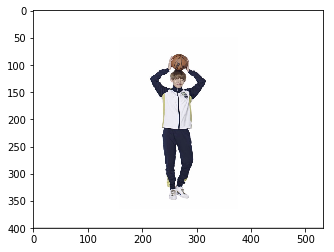

In [48]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

fname = 'final_model.jpg'

image = skimage.io.imread(fname)

width = image.shape[0]
height = image.shape[1]
print("width:", width, "height:", height)
plt.imshow(image)

image = skimage.transform.resize(image, [PH, PW], mode='constant', preserve_range=True).astype(np.uint8)
width = image.shape[0]
height = image.shape[1]
print("width:", width, "height:", height)
plt.imshow(image)


In [49]:
restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                            'CPM/PersonNet'))

with tf.Session(config=tf_config) as sess:
  restorer.restore(sess, person_net_path)
  b_image = image[np.newaxis] / 255.0 - 0.5
  hmap_person = sess.run(heatmap_person_large, { image_in : b_image })

print('done detecting')  
  
hmap_person = np.squeeze(hmap_person)  
centers = detect_objects_heatmap(hmap_person)  
b_pose_image, b_pose_cmap = prepare_input_posenet(b_image[0], centers, [PH, PW], [H, W])  

restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                            'CPM/PoseNet'))

with tf.Session(config=tf_config) as sess:
  restorer.restore(sess, pose_net_path)
  feed_dict = {
    pose_image_in : b_pose_image,
    pose_centermap_in : b_pose_cmap
  }
  _hmap_pose = sess.run(heatmap_pose, feed_dict)

print('done detecting')  

INFO:tensorflow:Restoring parameters from ../person_net.ckpt
done detecting
INFO:tensorflow:Restoring parameters from ../pose_net.ckpt
done detecting


In [50]:
print(centers)

[[192 259]
 [232 380]]


In [51]:
parts = detect_parts_heatmaps(_hmap_pose, centers, [H, W])
print(parts)

[[[110 275]
  [151 267]
  [158 243]
  [127 226]
  [110 250]
  [159 291]
  [134 316]
  [118 292]
  [224 251]
  [289 251]
  [330 259]
  [224 283]
  [281 291]
  [322 275]]

 [[240 396]
  [ 36 543]
  [ 36 543]
  [248 396]
  [117 298]
  [403 543]
  [247 396]
  [118 298]
  [191 306]
  [126 306]
  [329 273]
  [ 36 184]
  [126 306]
  [329 273]]]


In [53]:
COLORS_LIMBS = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
          [255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255]]

def draw_joints(image, parts):
  for idx, coord in enumerate(parts):
    y = coord[0]
    x = coord[1]
    color = COLORS_LIMBS[idx%len(COLORS_LIMBS)]
    print("x:", x, "y:", y, color)
    cv2.circle(image, (x,y), 3, color, 10)
    
# top head, bottom head, L shoulder, L elbow, L wrist, R shoulder, R elbow, R wrist, L hip, L knee, L ankle, R hip, R knee, R ankle 


#draw_joints(image, parts[0])

In [55]:
print(parts[0])

[[110 275]
 [151 267]
 [158 243]
 [127 226]
 [110 250]
 [159 291]
 [134 316]
 [118 292]
 [224 251]
 [289 251]
 [330 259]
 [224 283]
 [281 291]
 [322 275]]


line from x0,y0: 275 110 x1,y1: 267 151 color: 0
line from x0,y0: 243 158 x1,y1: 226 127 color: 1
line from x0,y0: 226 127 x1,y1: 250 110 color: 2
line from x0,y0: 291 159 x1,y1: 316 134 color: 3
line from x0,y0: 316 134 x1,y1: 292 118 color: 4
line from x0,y0: 251 224 x1,y1: 251 289 color: 5
line from x0,y0: 251 289 x1,y1: 259 330 color: 6
line from x0,y0: 283 224 x1,y1: 291 281 color: 7
line from x0,y0: 291 281 x1,y1: 275 322 color: 8


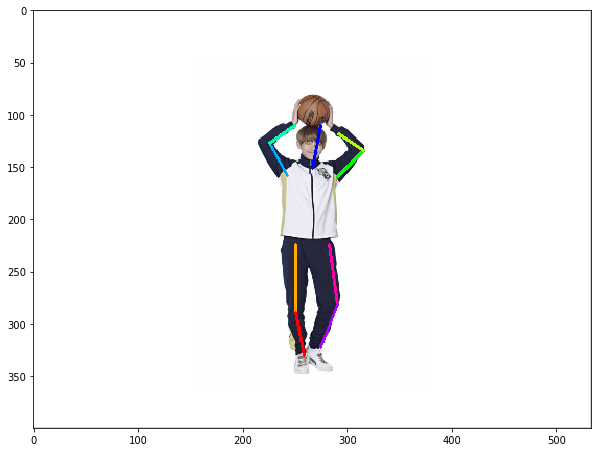

In [56]:
LIMBS = np.array([1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 13, 14]).reshape((-1,2))-1
COLORS_LIMBS = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
          [255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255]]
# dark blue, light blue, turqiose, green, light green, orange, red, pink, purple

def draw_limbs(image, parts):
  for lid, (p0, p1) in enumerate(LIMBS):
      y0, x0 = parts[p0]
      y1, x1 = parts[p1]
      print("line from x0,y0:", x0, y0,"x1,y1:", x1, y1, "color:", lid)
      cv2.line(image, (x0,y0), (x1,y1), COLORS_LIMBS[lid], 2)

# def draw_limbs(image, parts):
#   for oid in range(parts.shape[0]):
#     for lid, (p0, p1) in enumerate(LIMBS):
#       y0, x0 = parts[oid][p0]
#       y1, x1 = parts[oid][p1]
#       print("line from x0,y0:", x0, y0,"x1,y1:", x1, y1, "color:", lid)
#       cv2.line(image, (x0,y0), (x1,y1), COLORS_LIMBS[lid], 2)

draw_limbs(image, parts[0])
plt.figure(figsize=(10,10))
plt.imshow(image)